In [ ]:
# import zipfile

# with zipfile.ZipFile('/content/drive/MyDrive/train_dat/train_data.zip', 'r') as zip_ref:
#     zip_ref.extractall('/content/drive/MyDrive/train_dat')

In [ ]:
import os
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import cv2
import matplotlib.pyplot as plt

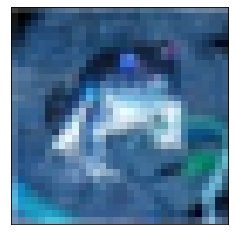

In [ ]:
# Example image plot
img1 = cv2.imread('/content/drive/MyDrive/train_dat/images/{:05d}.png'.format(1))
plt.imshow(img1)
plt.xticks([]) ## remove the ticks on x-axis
plt.yticks([]) ## remove the ticks on y-axis
plt.show()

In [ ]:

noisy = pd.read_csv('/content/drive/MyDrive/train_dat/noisy_labels.csv',header=None)
clean = pd.read_csv('/content/drive/MyDrive/train_dat/clean_labels.csv',header=None)


In [ ]:
images = []
for i in range(1,10001):
  images.append(cv2.imread('/content/drive/MyDrive/train_dat/images/{:05d}.png'.format(i)))
  if i % 1000 == 0:
    print(i)
images = torch.Tensor(np.stack(images))

In [ ]:
sz = 50
images_trainloader = torch.utils.data.DataLoader(images[:6000], batch_size=sz)
noisylabel_trainloader = torch.utils.data.DataLoader(nn.functional.one_hot(torch.Tensor(noisy[0].iloc[:6000].values).long()), batch_size=sz)
label_trainloader = torch.utils.data.DataLoader(nn.functional.one_hot(torch.Tensor(clean[0].iloc[:6000].values).long()), batch_size=sz)

images_valoader = torch.utils.data.DataLoader(images[6000:8000], batch_size=sz)
noisylabel_valoader = torch.utils.data.DataLoader(nn.functional.one_hot(torch.Tensor(noisy[0].iloc[6000:8000].values).long()), batch_size=sz)
label_valoader = torch.utils.data.DataLoader(nn.functional.one_hot(torch.Tensor(clean[0].iloc[6000:8000].values).long()), batch_size=sz)

images_testloader = torch.utils.data.DataLoader(images[8000:10000], batch_size=sz)
noisylabel_testloader = torch.utils.data.DataLoader(nn.functional.one_hot(torch.Tensor(noisy[0].iloc[8000:10].values).long()), batch_size=sz)
label_testloader = torch.utils.data.DataLoader(nn.functional.one_hot(torch.Tensor(clean[0].iloc[6000:8000].values).long()), batch_size=sz)



torch.Size([6000, 32, 32, 3])

In [28]:
class MyCNN(nn.Module):
    def __init__(self,num_class):
        super(MyCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 8 * 8 + num_class, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(64, num_class)
        self.sm1 = nn.Softmax(1)
        self.num_class = num_class

    def forward(self, x,y):
        y = torch.Tensor(y)
        
        x = x.permute(0,3,1,2)
        
        x = self.conv1(x)
        
        x = self.bn1(x)
        
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        x = x.reshape(x.shape[0],32*8*8)
        # print(x.shape,torch.Tensor(y).shape)
        x = torch.cat((x, y), dim=1)
        
        x = x.reshape(-1, 32 * 8 * 8 + self.num_class)
        x = self.fc1(x.float())
        
        x = self.bn3(x)
        
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.sm1(x)
        return x



model = MyCNN(nclass)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.L1Loss()

# number of epochs to run
# num_epochs = 5
# for epoch in range(num_epochs):
#     running_loss = 0.0
#     for i, (d, nl, l) in enumerate(zip(trainloader,noisylabel_loader,label_loader),1):
#         # print("LABELS")
#         # print(l)
#         # inputs, labels = data
#         # print(d.shape,nl.shape)
#         optimizer.zero_grad()
#         outputs = model(d,nl)
#         loss = criterion(outputs, l) #.unsqueeze(0)

#         # print(outputs,"labels",l)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()
#         print(running_loss)
#     print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, running_loss/len(trainloader)))


In [84]:
num_epochs = 50
patience = 3
best_val_loss = float('inf')
epochs_since_improvement = 0

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (d, nl, l) in enumerate(zip(images_trainloader, noisylabel_trainloader, label_trainloader), 1):
        optimizer.zero_grad()
        outputs = model(d, nl)
        loss = criterion(outputs, l)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print('Epoch [{}/{}], Training Loss: {:.4f}'.format(epoch+1, num_epochs, running_loss/len(trainloader)))
    
    with torch.no_grad():
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        for j, (val_d, val_nl, val_l) in enumerate(zip(images_valoader, noisylabel_valoader, label_valoader), 1):
            val_outputs = model(val_d, val_nl)
            val_loss += criterion(val_outputs, val_l).item()
            _, predicted = torch.max(val_outputs.data, 1)
            _, gt = torch.max(val_l.data, 1)
            total += val_l.size(0)
            correct += (predicted == gt).sum().item()
        val_loss /= len(images_valoader)
        val_acc = 100 * correct / total
        print('Epoch [{}/{}], Validation Loss: {:.4f}, Validation Accuracy: {:.2f}%'.format(epoch+1, num_epochs, val_loss, val_acc))
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pt')
        epochs_since_improvement = 0
    else:
        epochs_since_improvement += 1
        
    if epochs_since_improvement > patience:
        print('Stopping training after {} epochs without improvement'.format(epochs_since_improvement))
        break


Epoch [1/50], Training Loss: 0.0048
Epoch [1/50], Validation Loss: 0.1183, Validation Accuracy: 41.95%
Epoch [2/50], Training Loss: 0.0048
Epoch [2/50], Validation Loss: 0.1181, Validation Accuracy: 41.75%
Epoch [3/50], Training Loss: 0.0047
Epoch [3/50], Validation Loss: 0.1179, Validation Accuracy: 42.00%
Epoch [4/50], Training Loss: 0.0047
Epoch [4/50], Validation Loss: 0.1177, Validation Accuracy: 42.10%
Epoch [5/50], Training Loss: 0.0047
Epoch [5/50], Validation Loss: 0.1174, Validation Accuracy: 42.20%
Epoch [6/50], Training Loss: 0.0046
Epoch [6/50], Validation Loss: 0.1172, Validation Accuracy: 42.40%
Epoch [7/50], Training Loss: 0.0046
Epoch [7/50], Validation Loss: 0.1171, Validation Accuracy: 42.10%
Epoch [8/50], Training Loss: 0.0046
Epoch [8/50], Validation Loss: 0.1168, Validation Accuracy: 42.40%
Epoch [9/50], Training Loss: 0.0046
Epoch [9/50], Validation Loss: 0.1166, Validation Accuracy: 42.35%
Epoch [10/50], Training Loss: 0.0045
Epoch [10/50], Validation Loss: 0.11

In [90]:
# evaluation on test set
correct = 0
total = 0
for t, (t_d, t_nl, t_l) in enumerate(zip(images_testloader, noisylabel_testloader, label_testloader), 1):
  test_outputs = model(t_d, t_nl)
  # preds = torch.zeros_like(test_outputs).scatter_(1, torch.argmax(test_outputs, dim=1).unsqueeze(1), 1)
  correct += sum(torch.argmax(test_outputs, dim=1) == torch.argmax(t_l, dim=1))
  total += len(t_l)
accuracy = correct / total
print('Accuracy on the test set: %f' % (correct / total))

Accuracy on the test set: 0.428500


In [97]:
# benchmark
np.mean(noisy[0][:10000] == clean[0])

0.3968

In [ ]:
# sample data to test the network

#noisylabel_loader
# nn.functional.one_hot(torch.Tensor(noisy[0].iloc[:10000].values).long())
#label_loader
# nn.functional.one_hot(torch.Tensor(clean[0].values).long())

import random
# batch size 4
sz = 4
trainloader = torch.utils.data.DataLoader(torch.Tensor(np.random.rand(8,32,32,3)), batch_size=sz)
# number of classes 10
nclass = 10

ys = np.zeros(shape=(8,nclass))
for i in range(ys.shape[0]):
  labs = np.zeros(nclass)
  labs[random.randint(0,nclass-1)] = 1
  ys[i] = labs
noisylabel_loader = torch.utils.data.DataLoader(ys, batch_size=sz)

ys = np.zeros(shape=(8,nclass))
for i in range(ys.shape[0]):
  labs = np.zeros(nclass)
  labs[random.randint(0,nclass-1)] = 1
  ys[i] = labs
label_loader = torch.utils.data.DataLoader(ys, batch_size=sz)

for i, (d, nl, l) in enumerate(zip(trainloader,noisylabel_loader,label_loader),0):
  print(i,d.shape,nl.shape,l.shape)

0 torch.Size([4, 32, 32, 3]) torch.Size([4, 10]) torch.Size([4, 10])
1 torch.Size([4, 32, 32, 3]) torch.Size([4, 10]) torch.Size([4, 10])
